In [1]:
from datetime import timedelta
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models,transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,random_split
from __future__ import print_function
import numpy as np 
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt 
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import pickle
import cv2
import wandb
from sklearn.model_selection import KFold
# from torchsummary import summary
import glob
from sklearn.manifold import TSNE
import seaborn as sns
import collections

SAVING_FRAMES_PER_SECOND = 30

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.models.video import r3d_18

In [3]:
class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):
    def __init__(self, z_dim=32):
        super(ResNet18Enc, self).__init__()
        self.z_dim = z_dim
        self.ResNet18 = models.resnet18(pretrained=True)
        self.num_feature = self.ResNet18.fc.in_features
        self.ResNet18.fc = nn.Linear(self.num_feature, 1*self.z_dim)
        
    def forward(self, x):
        x = self.ResNet18(x)
        return x

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=32, nc=3):
        super().__init__()
        self.in_planes = 512

        self.linear = nn.Linear(z_dim, 512)

        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=1)
        self.conv1 = ResizeConv2d(64, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=7)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = F.interpolate(x, size=(112,112), mode='bilinear')
        x = torch.sigmoid(self.conv1(x))
        # [x, channels, height, width]
        x = x.view(x.size(0), 3, 224, 224)
        return x

class newVAE(nn.Module):

    def __init__(self, z_dim):
        super(newVAE, self).__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x):
        z = self.encoder(x)
#         mean, logvar = self.encoder(x)
#         z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x

    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [3]:
latent_vectors = []

In [4]:
full_video_vectors = []

In [5]:
action_vectors = {"Eat":[], "Sniff":[], "Groom":[], "Rest":[], "Walk":[], "Hang":[], "Rear":[]}

In [6]:
model = newVAE(32)
model = nn.DataParallel(model)
model = model.cuda()
model.load_state_dict(torch.load("new_architecture_MSE_e1550.p"))
model.eval()

def hook_fn(m, i, o):

    for grad in o:  
        try:
#             full_video_vectors.append(np.array(grad.cpu()))
            latent_vectors.append(np.array(grad.cpu()))
#             action_vectors[current_action].append(np.array(grad.cpu()))
        except AttributeError: 
            print ("None found for Gradient")

hook_handle = model.module.encoder.ResNet18.fc.register_forward_hook(hook_fn)

In [7]:
for video_number in range(1,6):
    print("Working on video", video_number)
    files = glob.glob('/home/anagara8/Documents/Autoencoder/video_sample'+str(video_number)+'-opencv/*.jpg')
    files.sort()
    for image in files:
        image = cv2.imread(image)
        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
        tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cpu()
        with torch.no_grad():
            reconstructed_frame = model(tensor_frame)
print("All done!")

Working on video 1


/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Working on video 2
Working on video 3
Working on video 4
Working on video 5
All done!


In [15]:
current_action = "Eat"
for video_action in ["Eat", "Eathand", "Sniff", "Groom", "Rest", "Walk", "Hang", "Rear"]:
    print("Working on video", video_action)
    files = glob.glob('/home/anagara8/Documents/Autoencoder/VideoActions/'+video_action+'/*.jpg')
    files.sort()
    for image in files:
        image = cv2.imread(image)
        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
        tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cpu()
        with torch.no_grad():
            reconstructed_frame = model(tensor_frame)
print("All done!")

Working on video Eat
Working on video Eathand
Working on video Sniff
Working on video Groom
Working on video Rest
Working on video Walk
Working on video Hang
Working on video Rear
All done!


In [128]:
for action in action_vectors.keys():
    print(action, "->", len(action_vectors[action]))

Eat -> 601
Sniff -> 601
Groom -> 601
Rest -> 601
Walk -> 601
Hang -> 360
Rear -> 601


In [9]:
len(full_video_vectors)

0

In [8]:
len(latent_vectors)

30720

In [17]:
latent_vectors = latent_vectors + full_video_vectors

## Principal Component Analysis

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc = StandardScaler()
sc.fit(latent_vectors)
copied_latent_vectors = sc.transform(latent_vectors)
np.mean(copied_latent_vectors),np.std(copied_latent_vectors)

(1.0788298687031513e-17, 1.0)

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='auto')
principalComponents = pca.fit_transform(copied_latent_vectors)
principalDf = pd.DataFrame(data = principalComponents)#, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [69]:
len(copied_latent_vectors)/2

55983.0

In [75]:
pca.fit_transform(copied_latent_vectors[55983:])

array([[ 6.9752828 , -1.38942884, -4.08074974],
       [ 6.64604643, -1.20190264, -4.5161814 ],
       [ 6.45262847, -0.9343115 , -5.16119907],
       ...,
       [-1.15926061,  0.49611499, -0.89239763],
       [-1.16314851,  0.45907312, -1.01664583],
       [-1.11632261,  0.40711237, -1.11969894]])

In [76]:
pca.fit_transform(copied_latent_vectors[0:55983])

array([[-0.18783698,  0.093489  , -0.62346658],
       [-0.06502421,  0.32036375, -0.53452759],
       [-0.05184945,  0.59659635, -0.52191785],
       ...,
       [ 3.96407681, -5.59959765,  5.59875751],
       [ 4.8960823 , -5.56202956,  6.41928911],
       [ 4.76356434, -5.29871167,  5.98889979]])

In [77]:
print(pca.explained_variance_ratio_)

[0.35704724 0.18613805 0.14520001]


In [24]:
action_vector_to_process = action_vectors

NameError: name 'action_vectors' is not defined

In [25]:
transformed_vectors = pca.transform(full_video_vectors)

In [39]:
# for action in action_vectors.keys():
x_values, y_values, z_values, time = [], [], [], []
count = 0
for frame_vector in transformed_vectors[0:1800]:
    x_values.append(frame_vector[0])
    y_values.append(frame_vector[1])
    z_values.append(frame_vector[2])
    time.append(count)
    count += 1

In [40]:
count

1800

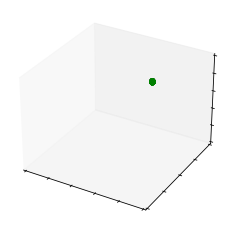

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.scatter3D(x_values, y_values, z_values, c='Green')

In [61]:
len(x_values)

1800

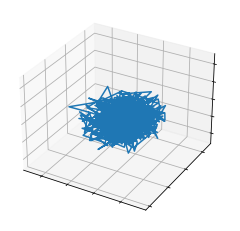

In [63]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def gen(n):
    phi = 0
    while phi < count:
        yield np.array([z_values[phi], x_values[phi], y_values[phi]])
        phi += 1

def update(num, data, line):
#     print(data[:2, :num])
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    
N = 1800
data = np.array(list(gen(N))).T
line, = ax.plot(z_values, x_values, y_values)

# Setting the axes properties
# ax.set_zlim([0.25, 2.5])
# ax.set_xlim([-2.5, -1.0])
# ax.set_ylim([-1.0, 3.0])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ani = animation.FuncAnimation(fig, update, N, fargs=(data, line), interval=30000/N, blit=False)
FFwriter = animation.FFMpegWriter(fps=30)
ani.save('five_minute_animation_final.mp4')
plt.show()

ValueError: too many values to unpack (expected 2)

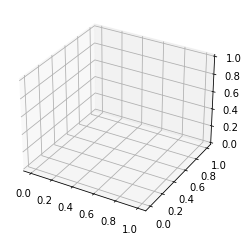

In [49]:
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
import numpy as np 
  
# creating a blank window
# for the animation 
fig = plt.figure() 
# axis = plt.axes(xlim =(-50, 50),
#                 ylim =(-50, 50)) 
ax = plt.axes(projection='3d')
# line, = axis.plot([], [], lw = 2) 
line, = ax.plot([], [], [], c='Green')
   
def init(): 
    line.set_data([], [], []) 
    return line, 
   
# initializing empty values
# for x and y co-ordinates
xdata, ydata, zdata = [], [], [] 
   
# animation function 
def animate(i): 
    # t is a parameter which varies
    # with the frame number 
       
    # x, y values to be plotted 
    x = x_values[i]
    y = y_values[i]
    z = z_values[i]
       
    # appending values to the previously 
    # empty x and y data holders 
    xdata.append(x) 
    ydata.append(y)
    zdata.append(z)
    line.set_data(xdata, ydata, zdata) 
      
    return line,
   
# calling the animation function     
anim = animation.FuncAnimation(fig, animate, init_func = init, 
                               frames = 500, interval = 20, blit = True) 
   
# saves the animation in our desktop
anim.save('growingCoil.mp4', writer = 'ffmpeg', fps = 30)

In [14]:
for action in action_vectors.keys():
    action_vector_to_process[action] = sc.transform(action_vector_to_process[action])
    action_vector_to_process[action] = pca.transform(action_vector_to_process[action])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [90]:
action_trajectories = {"Eat":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Sniff":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Groom":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Rest":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Walk":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Hang":{'X':[], 'Y':[], 'Z':[], 't':[]}, "Rear":{'X':[], 'Y':[], 'Z':[], 't':[]}}

In [27]:
for action in action_vectors.keys():
    count = 0
    for frame_vector in action_vector_to_process[action]:
        action_trajectories[action]['X'].append(frame_vector[0])
        action_trajectories[action]['Y'].append(frame_vector[1])
        action_trajectories[action]['Z'].append(frame_vector[2])
        action_trajectories[action]['t'].append(count)
        count += 1

NameError: name 'action_vectors' is not defined

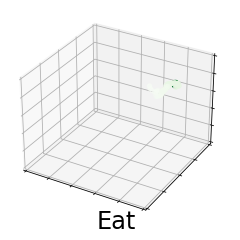

In [191]:
current_action = "Eat"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Eat",y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

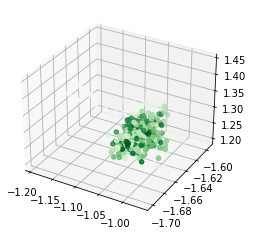

In [154]:
current_action = "Eat"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

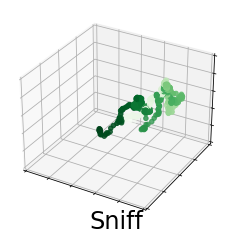

In [192]:
current_action = "Sniff"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Sniff",y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

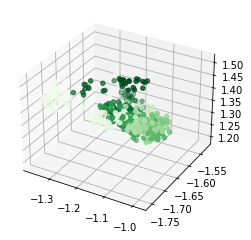

In [155]:
current_action = "Sniff"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

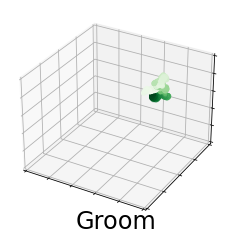

In [193]:
current_action = "Groom"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Groom",y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

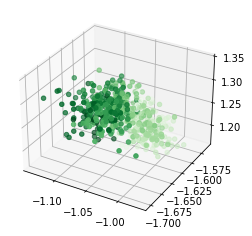

In [156]:
current_action = "Groom"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

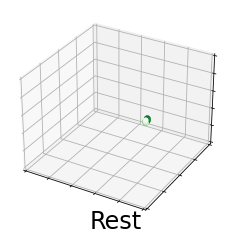

In [194]:
current_action = "Rest"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Rest", y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

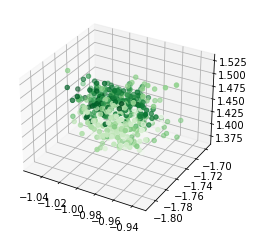

In [157]:
current_action = "Rest"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

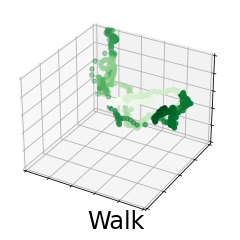

In [195]:
current_action = "Walk"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Walk", y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

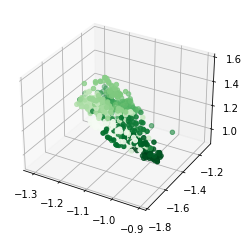

In [158]:
current_action = "Walk"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

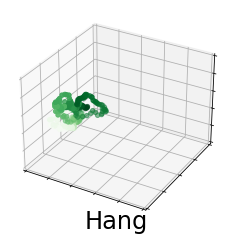

In [196]:
current_action = "Hang"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Hang", y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

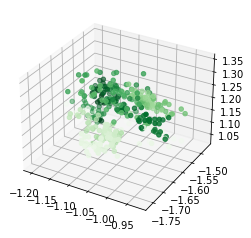

In [159]:
current_action = "Hang"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

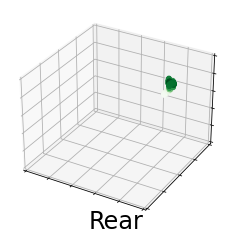

In [197]:
current_action = "Rear"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim([-6.0, 4.0])
ax.set_ylim([-4.0, 0.0])
ax.set_zlim([-2.0, 3.0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title("Rear", y=-0.05, fontsize=24)
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

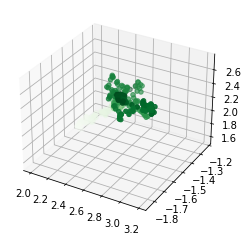

In [98]:
current_action = "Rear"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

In [15]:
len(set(action_labels))

NameError: name 'action_labels' is not defined

In [249]:
from matplotlib import animation
# import matplotlib.patches as mpatches

mapped_actions = []
action_mapper = {"Eat":1, "Sniff":6, "Groom":2, "Rest":0, "Walk":4, "Hang":5, "Rear":3}
action_colours = {"Eat":'tab:blue', "Sniff":'tab:orange', "Groom":'limegreen', "Rest":'deepskyblue', "Walk":'tab:pink', "Hang":'tab:purple', "Rear":'tab:brown'}
action_cmaps = {"Eat":'winter', "Sniff":'cool', "Groom":'Wistia', "Rest":'hot', "Walk":'summer', "Hang":'autumn', "Rear":'spring'}
for action in action_labels:
    mapped_actions.append(action_mapper[action])

x_values, y_values, z_values = [], [], []
for value in all_actions:
    x_values.append(value[0])
    y_values.append(value[1])
    z_values.append(value[2])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
x_values, y_values, z_values = [], [], []

mapped_actions = []
prev_action = None
timer = -1
action_time = []
for i in range(len(all_actions)):
#     if prev_action != action_labels[i]:
#         timer = 0
#     else:
#         timer += 1
#     prev_action = action_labels[i]
#     action_time.append(timer)
    value = all_actions[i]
    x_values.append(value[0])
    y_values.append(value[1])
    z_values.append(value[2])
#     mapped_actions.append(action_mapper[action_labels[i]])
    ax.scatter3D(x_values, y_values, z_values, c=action_colours[action_labels[i]])
    x_values, y_values, z_values = [], [], []
    action_time = []
    mapped_actions = []
    
# eat_legend = mpatches.Patch(color='tab:blue', label='Eat')
# sniff_legend = mpatches.Patch(color='tab:orange', label='Sniff')
# groom_legend = mpatches.Patch(color='limegreen', label='Groom')
# rest_legend = mpatches.Patch(color='deepskyblue', label='Rest')
# walk_legend = mpatches.Patch(color='tab:pink', label='Walk')
# hang_legend = mpatches.Patch(color='tab:purple', label='Hang')
# rear_legend = mpatches.Patch(color='tab:brown', label='Rear')

# plt.legend(handles=[eat_legend, sniff_legend, groom_legend, rest_legend, walk_legend, hang_legend, rear_legend], loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()
# ax.legend([1, 2, 3, 4, 5, 6, 7], ["a", "b", "c", "d", "e", "f", "g"])
# leg = ax.legend()

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('G.gif', writer=animation.PillowWriter(fps=20))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0ca6f16430> (for post_execute):


KeyboardInterrupt: 

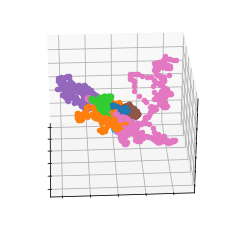

In [253]:
from matplotlib import animation

mapped_actions = []
action_mapper = {"Eat":1, "Sniff":6, "Groom":2, "Rest":0, "Walk":4, "Hang":5, "Rear":3}
action_colours = {"Eat":'tab:blue', "Sniff":'tab:orange', "Groom":'limegreen', "Rest":'deepskyblue', "Walk":'tab:pink', "Hang":'tab:purple', "Rear":'tab:brown'}
for action in action_labels:
    mapped_actions.append(action_mapper[action])

x_values, y_values, z_values = [], [], []
for value in all_actions:
    x_values.append(value[0])
    y_values.append(value[1])
    z_values.append(value[2])
    
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
x_values, y_values, z_values = [], [], []
plt.style.use('seaborn-dark-palette')
mapped_actions = []
prev_action = None
timer = -1
action_time = []
for i in range(len(all_actions)):
    if prev_action != action_labels[i]:
        timer = 0
    else:
        timer += 1
    prev_action = action_labels[i]
    action_time.append(timer)
    value = all_actions[i]
#     print("Value:", value)
    x_values.append(value[0])
    y_values.append(value[1])
    z_values.append(value[2])
    mapped_actions.append(action_mapper[action_labels[i]])
    ax.scatter3D(x_values, y_values, z_values, c=action_colours[action_labels[i]])#, cmap=action_cmaps[action_labels[i]])
    x_values, y_values, z_values = [], [], []
    action_time = []
    mapped_actions = []
# ax.legend(handles=set(action_labels), loc='center')

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('G.gif', writer=animation.PillowWriter(fps=20))

In [213]:
leg.__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <Axes3DSubplot:>,
 'figure': <Figure size 432x288 with 1 Axes>,
 '_transform': <matplotlib.transforms.IdentityTransform at 0x7f0c26ce03a0>,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x7f0c26ce0ac0>,
 '_remove_method': <bound method Axes._remove_legend of <Axes3DSubplot:>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'prop': <matplotlib.font_manager.FontProperties at 0x7f0c26ce0a30>,
 '_fontsize': 10.0,
 'texts': [],
 'legendHandles': [],
 '_legend_title_box': <matplotlib.offsetbox.TextArea at 0x7f0c26cfaee0>,
 '_custom_handler_map': 

In [ ]:
current_action = "Rear"
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(action_trajectories[current_action]['X'], action_trajectories[current_action]['Y'], action_trajectories[current_action]['Z'], c = action_trajectories[current_action]['t'], cmap='Greens');

## t-Distributed Stochastic Neighbor Embedding

In [99]:
all_actions = []
action_labels = []

for action in action_vectors.keys():
    for vector in action_vectors[action]:
        action_labels.append(action)
        all_actions.append(vector)
    
print(len(all_actions), "x", len(all_actions[0]))
print(len(action_labels))

3966 x 3
3966


In [100]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(all_actions)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anagara8/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3966 samples in 0.004s...
[t-SNE] Computed neighbors for 3966 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3966
[t-SNE] Computed conditional probabilities for sample 2000 / 3966
[t-SNE] Computed conditional probabilities for sample 3000 / 3966
[t-SNE] Computed conditional probabilities for sample 3966 / 3966
[t-SNE] Mean sigma: 0.024938
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.804298
[t-SNE] KL divergence after 2000 iterations: 0.418998
t-SNE done! Time elapsed: 9.724191427230835 seconds


In [101]:
print(tsne_results.shape)
df = pd.DataFrame(tsne_results, columns = ['Axis1','Axis2'])#,'Column_C'])

(3966, 2)


[Text(0.5, 1.0, 'NIH Animal Data T-SNE projection')]

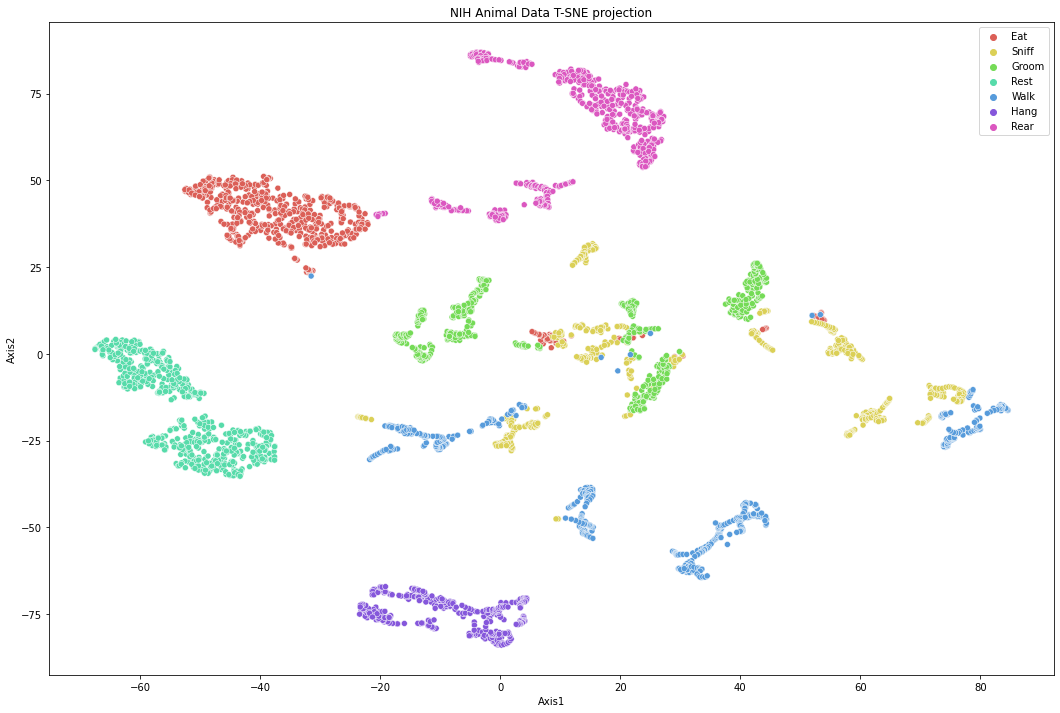

In [102]:
y = [i for i in range(len(action_vectors[current_action]))]

fig = plt.gcf()
fig.set_size_inches(18, 12)
sns.scatterplot(x="Axis1", y="Axis2", hue=action_labels,
                palette=sns.color_palette("hls", 7),
                data=df).set(title="NIH Animal Data T-SNE projection")

[Text(0.5, 1.0, 'NIH Animal Data T-SNE projection')]

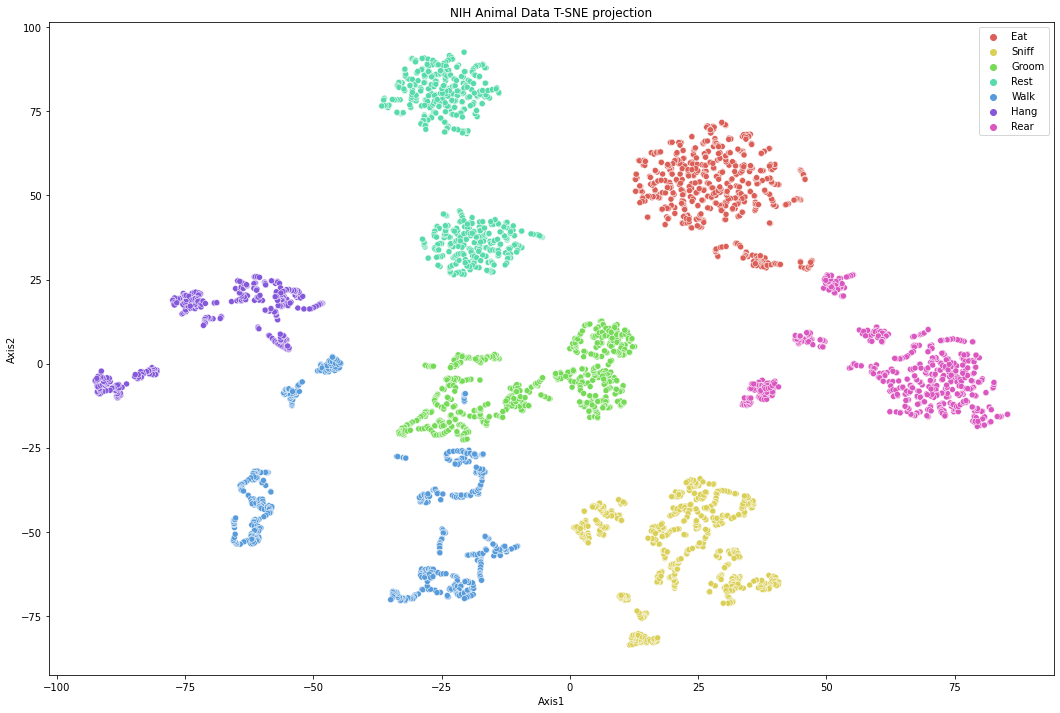

In [210]:
y = [i for i in range(len(action_vectors[current_action]))]

fig = plt.gcf()
fig.set_size_inches(18, 12)
sns.scatterplot(x="Axis1", y="Axis2", hue=action_labels,
                palette=sns.color_palette("hls", 7),
                data=df).set(title="NIH Animal Data T-SNE projection")

Processing: Hang
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480

3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3


3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
Processing: Sniff
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 

480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224
480 640 3
3 224 224


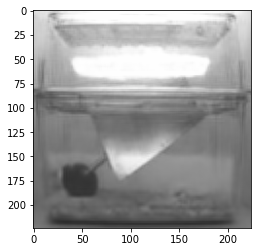

In [35]:
video_actions = os.listdir('/home/anagara8/Documents/Autoencoder/VideoActions')
for action_class in video_actions:
    print("Processing:", action_class)
    if not os.path.isdir("VideoActionsReconstructed/"+action_class+"_reconstructed"):
        os.makedirs("VideoActionsReconstructed/"+action_class+"_reconstructed")
    files = glob.glob('/home/anagara8/Documents/Autoencoder/VideoActions/'+action_class+'/*.jpg')
    files.sort()
    for image in files:
        image_name = image.split('.jpg')[0].split('/')[-1]
        image = cv2.imread(image)
        print(len(image), len(image[0]), len(image[0][0]))
        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
#         plt.imshow(image, cmap='gist_gray')
        tensor_frame = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).cuda()
        
        with torch.no_grad():
            reconstructed_frame = model(tensor_frame) 
        reconstructed_frame = reconstructed_frame[0]
        print(len(reconstructed_frame), len(reconstructed_frame[0]), len(reconstructed_frame[0][0]))#, len(reconstructed_frame[0][0][0]))
#         temp_rec_img = torch.permute(rec_img[0].cpu(), (1, 2, 0))
        temp = torch.permute(reconstructed_frame.cpu(), (1, 2, 0))
        plt.imshow(temp, cmap='gist_gray')
        cv2.imwrite(os.path.join("/home/anagara8/Documents/Autoencoder/VideoActionsReconstructed/", action_class + "_reconstructed/", image_name+".jpg"), np.array(temp*255))                   

In [34]:
current_action = "Eat"
action_results = tsne.fit(action_vectors[current_action])
# print(action_vectors[current_action])
# action_dataframe = pd.DataFrame(action_results, columns = ['Column_A','Column_B'])#,'Column_C'])

NameError: name 'tsne' is not defined

<AxesSubplot:xlabel='Column_A', ylabel='Column_B'>

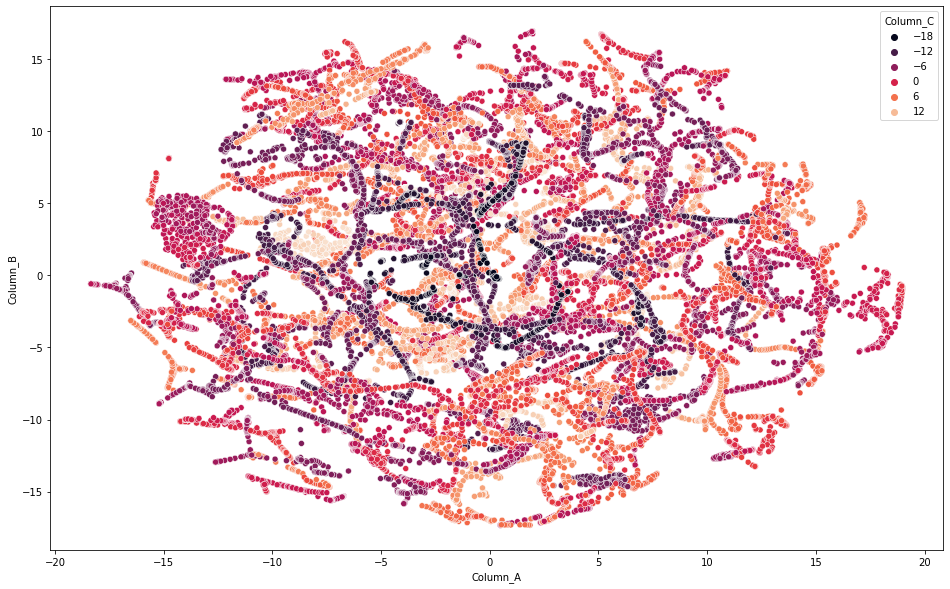

In [32]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="Column_A", y="Column_B",
    hue="Column_C",
    palette=sns.color_palette("rocket", as_cmap=True),
    data=df,
#     legend="full",
#     alpha=0.3
)